In [63]:
import math

import numpy as np
import pandas as pd
import seaborn as sb
import networkx as nx
from sklearn.metrics import mutual_info_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from heapq import heappop, heappush
from itertools import count

def error_gauss(p, mu, n, d):
    """
    Used for plotting the error bound
    :param p: 
    :param mu: 
    :param n: 
    :return: 
    """
    
    return 2*(d-1) * math.log(n)/(n*math.sqrt(p))*math.sqrt(-math.log(mu/(d**2))) 

def noise_variance(n:int, d:int, p:float) -> float:
    """
    Function that is injected as the noise parameter
    :param n: 
    :param d: 
    :param p: 
    :return: 
    """
    return (np.log(n) * d / n )** 2 /2  / p
def format_edges(weight) -> str:
    """
    simple str util
    :param weight: 
    :return: 
    """
    if weight<0.03:
        return ""
    else:
        return f"{weight:.3f}"

def single_mi(x, y, bins) -> float:
    """
    Calculates the mutual information of two data rows (columns)
    :param x: 
    :param y: 
    :param bins: 
    :return: 
    """
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def generate_mi(ds, multicore=0):
    """
    Generates mutual information matrix. "might" be inefficient for large values
    :param ds: 
    :return: 
    """
    # num_cores = 0 if multicore> 0 else multiprocessing.cpu_count()
    d = ds.shape[1]
    mi_gen = np.zeros((d, d))

    print("Progress: ",  end="")
    for ix in np.arange(d):
        r = Parallel(n_jobs=-1)(delayed(single_mi)(dataset.iloc[:, ix].values, dataset.iloc[:, jx].values, 10) for jx in np.arange(ix, d))
        for idx, val in enumerate(r):
            mi_gen[ix, ix + idx]= val
            mi_gen[idx+ix, ix] = val # Preserving Symmetry
        print(f'{r}', end=" ")
        #for jx in np.arange(ix, n):
        #    print(f'Working on column: {ix}/{jx}')
        #    mi_gen[ix,jx]= single_mi(dataset.iloc[:, ix].values, dataset.iloc[:, jx].values, 10)
        #    mi_gen[jx, ix] = mi_gen[ix, jx] # Preserving Symmetry
    # Add symmetry
    print(mi_gen)
    return mi_gen


def mst(mutual_information, G=None):
    """
    Enables calculating a spanning tree using the networkX library
    :param mutual_information: 
    :return: 
    """
    G = nx.from_numpy_array(mutual_information.copy()) if G is None else G
    
    print(f'The Graph {G}')
    T = nx.maximum_spanning_tree(G, algorithm='prim')
    return (G,  ## Graph
            T, ## Spanning Tree
            sum (d['weight'] for _,_,d in T.edges(data=True)) ## Weight on this one. 
            )
    
def private_mst(mi, amount_noise):
    """
    Adds noise to mutual information, generates a spanning tree and then transfers back to the original edges
    :param mi: 
    :param amount_noise: 
    :return: 
    """
    print(f'Dimensions: {d} and datapoints: {n}')
    mi_noisy= np.add(mi, np.random.normal(0, amount_noise, size=(d,d))) ## Adds noise
    G = nx.from_numpy_array(mutual_information.copy())
    (_, T, mst_weight) = mst(mi_noisy) 
    return G, T, sum_weights(G, T)  # Maps the new weight to the original ones

def sum_weights(original_graph, spanning_tree) -> float:
    """
   Takes a graph and a set of edges and calculates the weight.
   
   Can be used to return the weight of a spanning tree for given edges
    :param original_graph: 
    :param spanning_tree: 
    :return:  
    """
    return sum(
        original_graph[e[0]][e[1]]['weight']
        for e in spanning_tree.edges()
    )
def load_ds(extracted_dims:int):
    ds=pd.read_csv("./datasets/retail.dat.txt",
                   header=0,
                   delim_whitespace=True,
                   on_bad_lines='skip',
                   dtype='Int64'
                   )
    print("Finished Loading dataset")
    
    feature_vector_ds = pd.DataFrame(columns=range(extracted_dims))
    feature_vector_ds.reset_index(drop=True)
    
    rows = []
    for idx, r in ds.iterrows():
        row = [0] * extracted_dims
        for el in r:
            if pd.isna(el) or el >= extracted_dims: continue # little data cleaning
            if el >= extracted_dims: break
            row[el] = 1
        rows.append(row)
    feature_vector_ds = pd.DataFrame.from_records(rows)
    feature_vector_ds.columns = range(extracted_dims)
    
    print(f'Finished loading dataset with {extracted_dims} dimensions and {len(ds)} rows')
    print(ds.head())
    return extracted_dims, len(ds), feature_vector_ds


# Privaccy enhanced prims algorithm
# @nx._dispatch(preserve_all_attrs=True)
def private_prim_tree(G):
    edges = pamst(G, )
    T = G.__class__()  # Same graph class as G
    T.graph.update(G.graph)
    T.add_nodes_from(G.nodes.items())
    T.add_edges_from(edges)
    return T
    
    
## happily taken from https://github.com/networkx/networkx/blob/main/networkx/algorithms/tree/mst.py
# @nx._dispatch(edge_attrs="weight", preserve_edge_attrs="data")
def pamst(G, minimum=False, weight="weight", data=True):
    """Iterate over edges of Prim's algorithm min/max spanning tree.

    Parameters
    ----------
    G : NetworkX Graph
        The graph holding the tree of interest.

    minimum : bool (default: True)
        Find the minimum (True) or maximum (False) spanning tree.

    weight : string (default: 'weight')
        The name of the edge attribute holding the edge weights.

    data : bool (default: True)
        Flag for whether to yield edge attribute dicts.
        If True, yield edges `(u, v, d)`, where `d` is the attribute dict.
        If False, yield edges `(u, v)`.

    """
    push = heappush
    pop = heappop

    nodes = set(G)
    c = count()
    sign = 1 if minimum else -1
    while nodes:
        u = nodes.pop()
        frontier = []
        visited = {u}
        for v, d in G.adj[u].items():
            wt = d.get(weight, 1) * sign
            push(frontier, (wt, next(c), u, v, d))
        while nodes and frontier:
            W, _, u, v, d = pop(frontier)
            if v in visited or v not in nodes:
                continue
            if data:
                yield u, v, d
            else:
                yield u, v
            # update frontier
            visited.add(v)
            nodes.discard(v)
            for w, d2 in G.adj[v].items():
                if w in visited:
                    continue
                new_weight = d2.get(weight, 1) * sign
                push(frontier, (new_weight, next(c), v, w, d2))

In [ ]:
## Assuming binary dataset with sensitivity d log n / n

d = 20 # num dims
p = 0.01 # zCDP
n = 1000 # num samples
mu  = 0.0001
# probabilty to stay outside the bound of a max error.

## With probability 1 - m, error is not larger as the bound
numDS = 1000
values = np.random.normal(0, (d**2 * np.log(n)**2) / (2 * p * n**2), size=(numDS, d*d))
a = [max(abs(x), key=abs) for x in values] # max error

# printing max error per round
plot = sb.histplot(a)
sigma = (d * np.log(n) / n / np.sqrt(2 * p))
threshold =  (sigma) * np.sqrt(np.log(d / mu))
print(threshold)

plot.axvline(x = threshold,    # Line on x = 2
           ymin = 0, # Bottom of the plot
           ymax = 1) # Top of the plot

In [8]:
# Load Data
columns = [3,6,7,8,9,10,11,17,24]

# Old dataset.
# dataset=pd.read_csv("./datasets/Surgical-deepnet.csv", header=0, usecols=columns, index_col=0)



Finished Loading
Finished loading dataset with 20 dimensions and 85548 rows
   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  \
0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

   19  
0   0  
1   0  
2   0  
3   0  
4   0  


MST on Real Graph 0.20138706906229925


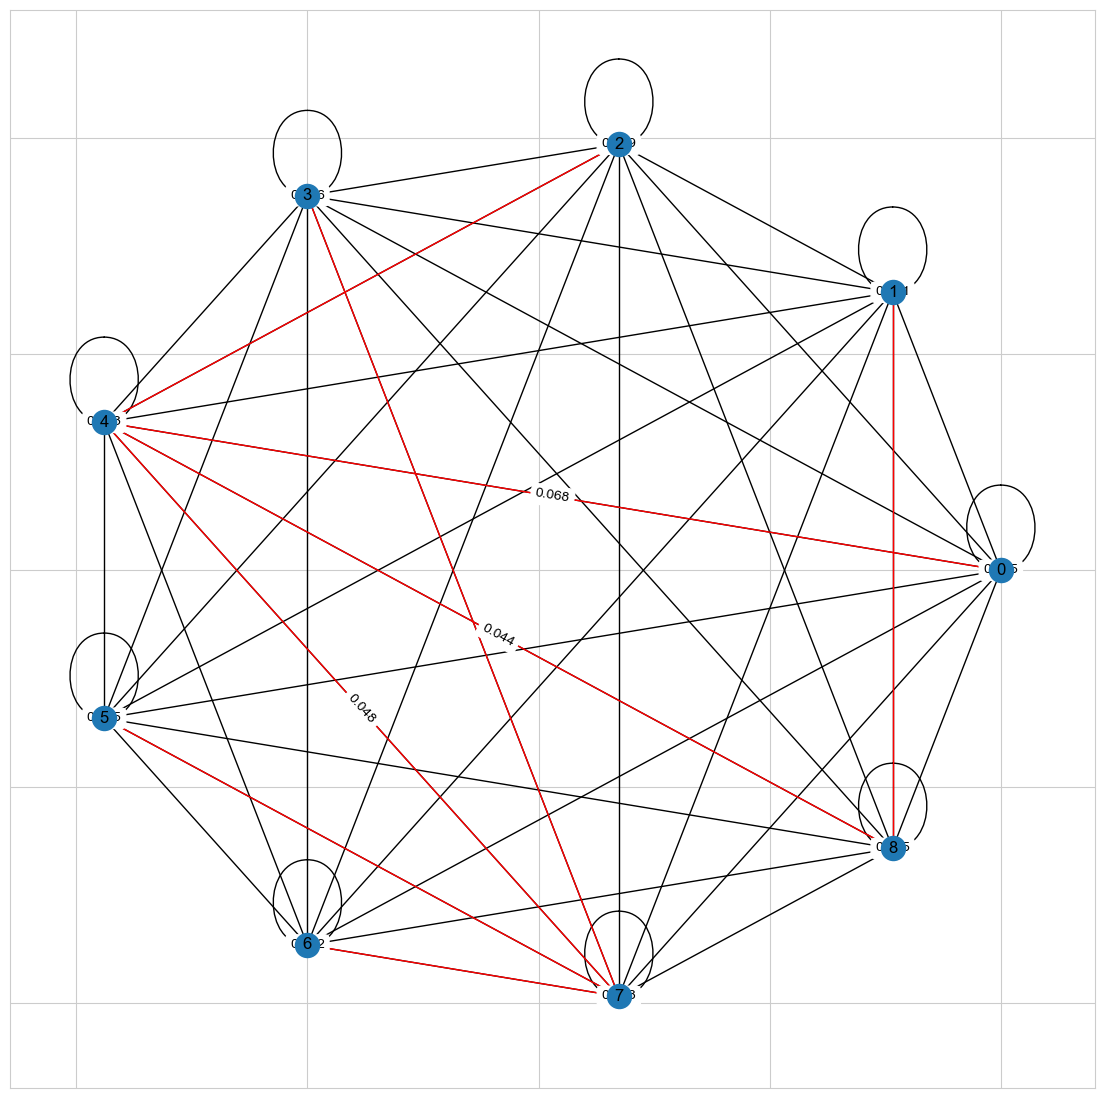

In [21]:
## Step 1: real MST

mutual_information = generate_mi(dataset)
G = nx.from_numpy_array(mutual_information)
G = nx.convert_node_labels_to_integers(G)
T= nx.maximum_spanning_tree(G, algorithm ='prim')

# Calculating the Real weight
weight = 0
for _,_,d in T.edges(data=True):
    weight += d['weight']
print(f'MST on Real Graph {weight}')

plt.figure(3,figsize=(14,14))
pos = nx.circular_layout(G, scale=40)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(T, pos, edge_color="red")
nx.draw_networkx_labels(G, pos)
# edge weight labels
edge_labels = dict([((u,v,), format_edges(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels)
# larger figure size
plt.show()

We have 14635 samples on 9 dimensions
MST on Real Graph 0.20138706906229925
MST on Fake Graph 0.2161310732983846


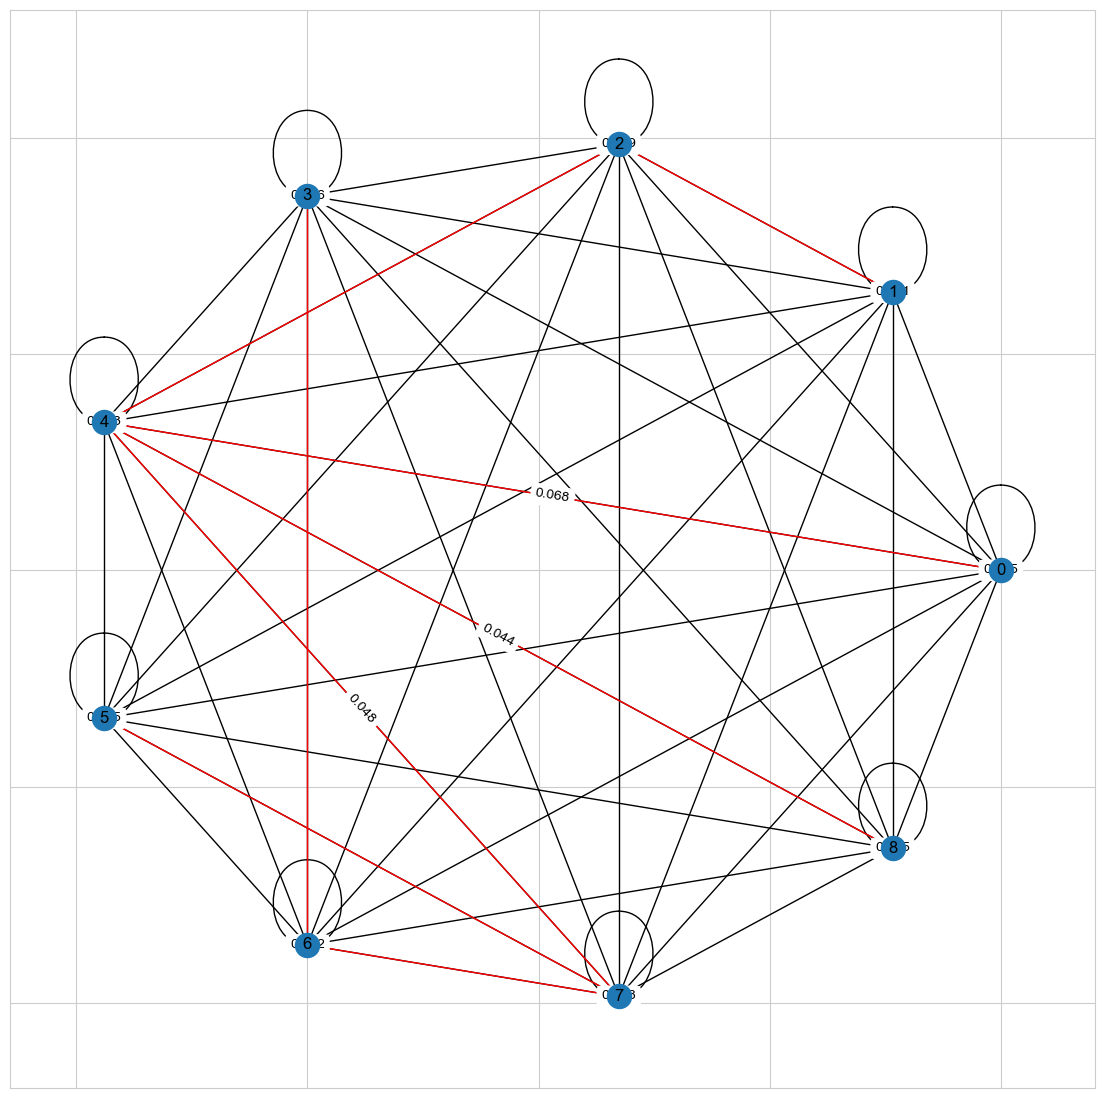

In [22]:
# Step 2: Noisy MST
   
p = 1 # privacy rho
d = len(columns)

(T1, private_weight) = private_mst(p, dataset)
(spanning_tree, real_weight) = private_mst(p, dataset, priv=False)
G = nx.convert_node_labels_to_integers(G)

# Calculating the Real weight
print(f'We have {n} samples on {d} dimensions')
print(f'MST on Real Graph {real_weight}')
print(f'MST on Fake Graph {private_weight}')

plt.figure(3,figsize=(14,14))
pos = nx.circular_layout(G, scale=40)  # positions for all nodes - seed for reproducibility

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_edges(T1, pos, edge_color="red")
nx.draw_networkx_labels(G, pos)
# edge weight labels
edge_labels = dict([((u,v,), format_edges(d['weight'])) for u,v,d in G.edges(data=True)])

nx.draw_networkx_edge_labels(G, pos, edge_labels)
# larger figure size
plt.show()

Finished Loading dataset
Finished loading dataset with 1000 dimensions and 85548 rows
    0   1   2     3     4     5     6     7     8     9  ...    20    21  \
0  30  31  32  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...  <NA>  <NA>   
1  33  34  35  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...  <NA>  <NA>   
2  36  37  38    39    40    41    42    43    44    45  ...  <NA>  <NA>   
3  38  39  47    48  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...  <NA>  <NA>   
4  38  39  48    49    50    51    52    53    54    55  ...  <NA>  <NA>   

     22    23    24    25    26    27    28    29  
0  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
1  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
2  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
3  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
4  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  

[5 rows x 30 columns]
Starting with n=85548 and d=1000
The Graph Graph with 1000 nodes and 500500 edges
Graph with 1000 nodes and 999 edges
Dime

(-1.0, 2.0)

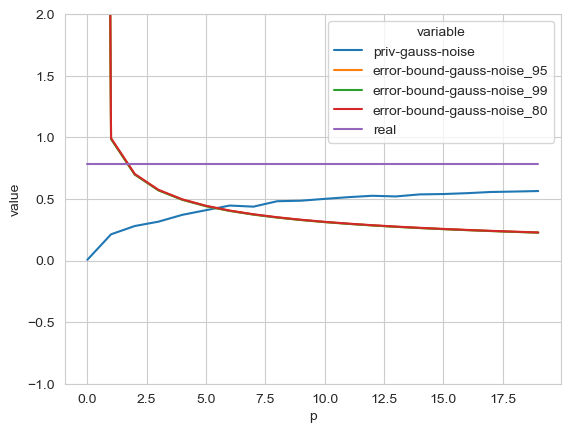

In [58]:
p_series = pd.DataFrame()
(d, n, dataset) = load_ds(1000)

# disable warnings
import warnings
warnings.filterwarnings("ignore")
                        
# Metaparams
RHO_UP = 20
RHO_LOW = 0.001
STEP = 1
mu = 0.99 # confidence interval

print(f'Starting with n={n} and d={d}')
# mutual_information = generate_mi(dataset)
(G, spanning_tree, real_weight) = mst(mutual_information[:])
print(spanning_tree)
for p in np.arange(RHO_LOW,RHO_UP, STEP):
    noise = noise_variance(n, d, p)
    (G, T1, private_weight) = private_mst(mi=mutual_information[:], amount_noise=noise)
    row = {
        "p": p,
        "priv-gauss-noise": private_weight, 
        "error-bound-gauss-noise_95": error_gauss(p, 0.95, n, d),
        "error-bound-gauss-noise_99": error_gauss(p, 0.99, n, d),
        "error-bound-gauss-noise_80": error_gauss(p, 0.8, n, d),
        "real": real_weight}
    p_series = p_series.append(row, ignore_index=True)

print(f'We have {len(dataset)} samples on {d} dimensions')
print(f'MST on Real Graph {real_weight}')
print(f'MST on Fake Graph {private_weight}')
ax = sb.lineplot(x='p', y='value', hue='variable',
            data=pd.melt(p_series, ['p']))
ax.set_ylim(-1,2)



In [ ]:
spanning_tree.edges()

We have -1 samples on -1 dimensions
MST on Real Graph 0.0023757128138483636
MST on Fake Graph 0.08203354189144658


<Axes: xlabel='p', ylabel='value'>

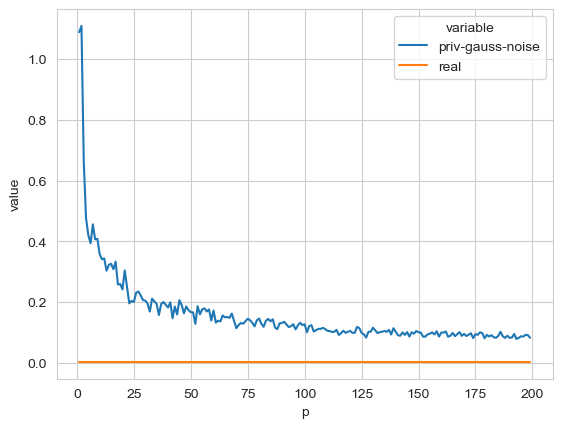